In [21]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import style

#### Importing data

In [2]:
msn_users = pd.read_csv("Data/users.csv")

In [3]:
msn_users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [4]:
msn_events = pd.read_csv("Data/events.csv")

In [5]:
msn_events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [12]:
msn_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340832 entries, 0 to 340831
Data columns (total 7 columns):
user_id        340832 non-null float64
occurred_at    340832 non-null object
event_type     340832 non-null object
event_name     340832 non-null object
location       340832 non-null object
device         340832 non-null object
user_type      325255 non-null float64
dtypes: float64(2), object(5)
memory usage: 18.2+ MB


In [6]:
msn_emails = pd.read_csv("Data/emails.csv")

In [7]:
msn_emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


MySQL local connection

In [ ]:
driver = "mysql+pymysql:"
user = "root"
password = "ironhack"
ip = "127.0.0.1"
database = "internal_messenger"

In [ ]:
connection_string = f"{driver}//{user}:{password}@{ip}/{database}"
engine = create_engine(connection_string)

POSTGRESQL local connection

In [15]:
driver = "postgresql:"
user = "postgres"
password = "ironhack"
ip = "localhost:5432"
database = "internal_messenger"

In [17]:
postgresql_connection_string = f"{driver}//{user}:{password}@{ip}/{database}"
engine = create_engine(postgresql_connection_string)

#### Uploading data to the POSTGRESQL DB

In [ ]:
msn_users.to_sql("users", con=engine, if_exists="append", index=False)

In [ ]:
msn_events.to_sql("events", con=engine, if_exists="append", index=False)

In [ ]:
msn_emails.to_sql("emails", con=engine, if_exists="append", index=False)

## Queries. Finding reasons behind the user engagement drop

#### Fetching all data from the db

In [11]:
query_users_pg = """
SELECT *
FROM users;
"""

In [12]:
users = pd.read_sql(query_users_pg, engine)

In [13]:
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,None,pending
2,2.0,2013-01-01 10:59:05,51.0,english,None,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [14]:
query_events_pg = """
SELECT *
FROM events;
"""

In [15]:
events = pd.read_sql(query_events_pg, engine)

In [16]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [17]:
query_emails_pg = """
SELECT *
FROM emails;
"""

In [18]:
emails = pd.read_sql(query_emails_pg, engine)

In [19]:
emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


## The issue. A drop in user engagement

In [82]:
query_issue = """
SELECT SUBSTR(((DATE_TRUNC('week', occurred_at::date)))::text, 6, 5) AS week,
 COUNT(DISTINCT user_id) AS weekly_active_users
FROM events
WHERE event_name = 'login'
GROUP BY week
ORDER BY week;
"""
user_engagement = pd.read_sql(query_issue, engine)

In [83]:
user_engagement

,week,weekly_active_users
0,04-28,701
1,05-05,1054
2,05-12,1094
3,05-19,1147
4,05-26,1113
5,06-02,1173
6,06-09,1219
7,06-16,1262
8,06-23,1249
9,06-30,1271


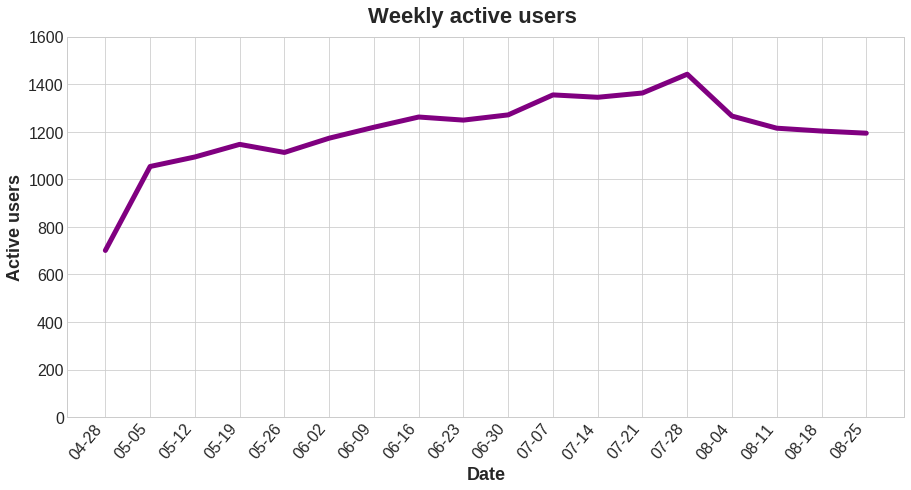

In [300]:
with plt.style.context('seaborn-whitegrid'):
    
    fig, ax = plt.subplots(figsize=(15,7))
    fig.suptitle("Weekly active users", fontsize=22, fontweight=650, y=0.94)
    
    sns.lineplot(user_engagement["week"], user_engagement["weekly_active_users"], lw=5, color="purple")
    ax.set_ylim(0, 1600)
    ax.tick_params(axis="x", labelsize=16, rotation=50)
    ax.tick_params(axis="y", labelsize=16)
    ax.set_xlabel("Date", fontsize=18, fontweight=650)
    ax.set_ylabel("Active users", fontsize=18, fontweight=650)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

    plt.show()

## Holidays

Do I keep this one below??

In [24]:
query_holidays = """
SELECT location, DATE_TRUNC('week', occurred_at::date) AS week, COUNT(DISTINCT user_id)
FROM events
WHERE event_name = 'login'
GROUP BY location, week
ORDER BY location, week;
"""

holidays_0 = pd.read_sql(query_holidays, engine)

In [25]:
holidays_0.head()

,location,week,count
0,Argentina,2014-04-27 22:00:00+00:00,1
1,Argentina,2014-05-04 22:00:00+00:00,5
2,Argentina,2014-05-11 22:00:00+00:00,6
3,Argentina,2014-05-18 22:00:00+00:00,7
4,Argentina,2014-05-25 22:00:00+00:00,5


*This query below tries to find the countries where the number of active users in august was greater than in july. In order to consider holidays as the reason for the user engagement drop we would like to see in the query output a list of countries where august is not the main vacation month, which we would expect either from countries whose tradition makes that the predominant vacation month is none in particular, or just another one because of for example, being located in the south hemisphere.*

In [39]:
query_holidays= """
SELECT sub3.location
FROM(
    SELECT sub2.*
    FROM(
        SELECT sub1.*, LAG(sub1.active_users, 1) OVER (PARTITION BY sub1.location) AS active_users_t0
        FROM(
            SELECT location, EXTRACT('month' FROM occurred_at::date) AS month,
             COUNT(DISTINCT user_id) as active_users
            FROM events
            WHERE event_name = 'login'
            GROUP BY location, month
            ) sub1
        ) sub2
    WHERE sub2.month = 8
    ) sub3
WHERE sub3.active_users - sub3.active_users_t0 > 0;
"""

holidays_1 = pd.read_sql(query_holidays, engine)

In [40]:
holidays_1

,location
0,Colombia
1,Denmark
2,Egypt
3,Greece
4,Indonesia
5,Iraq
6,Ireland
7,Malaysia
8,Pakistan
9,Philippines


I am Spanish and I can confirm august is traditionally the predominant vacation month. Well, here below is how the engagement user looks like by month in Spain

In [18]:
query_holidays= """
SELECT LEFT((DATE_TRUNC('month', occurred_at::date))::text, 7) AS month,
 COUNT(DISTINCT user_id) AS monthly_active_users
FROM events
WHERE event_name = 'login' AND location = 'Spain'
GROUP BY month;
"""
holidays_2 = pd.read_sql(query_holidays, engine)

In [281]:
holidays_2["month"] = holidays_2["month"].apply(lambda x: int(x))

ValueError: invalid literal for int() with base 10: '2014-06'

In [19]:
holidays_2.head()

,month,monthly_active_users
0,2014-05,45
1,2014-06,49
2,2014-07,45
3,2014-08,52


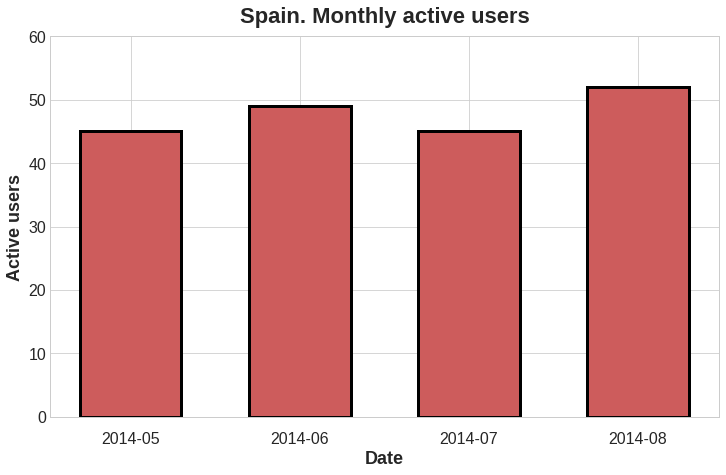

In [251]:
with plt.style.context('seaborn-whitegrid'):
    
    plt.figure(figsize=(12,7))
    plt.title("Spain. Monthly active users", fontsize=22, fontweight=650, y=1.02)
    
    plt.bar(holidays_2["month"], holidays_2["monthly_active_users"], color="indianred", width=0.6,
            edgecolor="black", linewidth=3)
    plt.ylim(0, holidays_2.monthly_active_users.max()+8)
    plt.tick_params(axis="x", labelsize=16, pad=15)
    plt.tick_params(axis="y", labelsize=16)
    plt.xlabel("Date", fontsize=18, fontweight=650)
    plt.ylabel("Active users", fontsize=18, fontweight=650)

    plt.show()

This in particular somewhat discourages me to think that holidays is the reason for the user engagement drop. [Develop]

### Broken feature

#### Device type

In [50]:
query_model_device = """
SELECT DISTINCT device
FROM events;
"""
device_0 = pd.read_sql(query_model_device, engine)

Below are listed all the model devices that have been used to log into the intranet

In [51]:
device_0

,device
0,samsumg galaxy tablet
1,asus chromebook
2,samsung galaxy note
3,iphone 5s
4,nexus 10
5,nokia lumia 635
6,macbook air
7,iphone 5
8,dell inspiron desktop
9,htc one


In [161]:
query_model_device = """
SELECT sub1.device_type AS device_type,
 SUBSTR(((DATE_TRUNC('week', occurred_at::date)))::text, 6, 5) AS week,
 COUNT(DISTINCT user_id) as active_users
FROM(
    SELECT *,
    CASE WHEN device IN ('nexus 10', 'windows surface', 'nexus 7', 'kindle fire') 
          OR device LIKE '%%pad%%' OR device ILIKE '%%tablet%%' THEN 'tablet'
         WHEN device IN ('nexus 5', 'samsung galaxy note', 'samsung galaxy s4', 'htc one', 'nokia 635')
          OR device LIKE '%%phone%%' THEN 'phone'
         ELSE 'laptop/PC' END AS device_type
    FROM events
    ) sub1
WHERE event_name = 'login'
GROUP BY device_type, week
ORDER BY week, device_type; 
"""

device_1 = pd.read_sql(query_model_device, engine)

In [162]:
device_1.head(10)

,device_type,week,active_users
0,laptop/PC,04-28,358
1,phone,04-28,262
2,tablet,04-28,198
3,laptop/PC,05-05,619
4,phone,05-05,427
5,tablet,05-05,332
6,laptop/PC,05-12,600
7,phone,05-12,459
8,tablet,05-12,350
9,laptop/PC,05-19,629


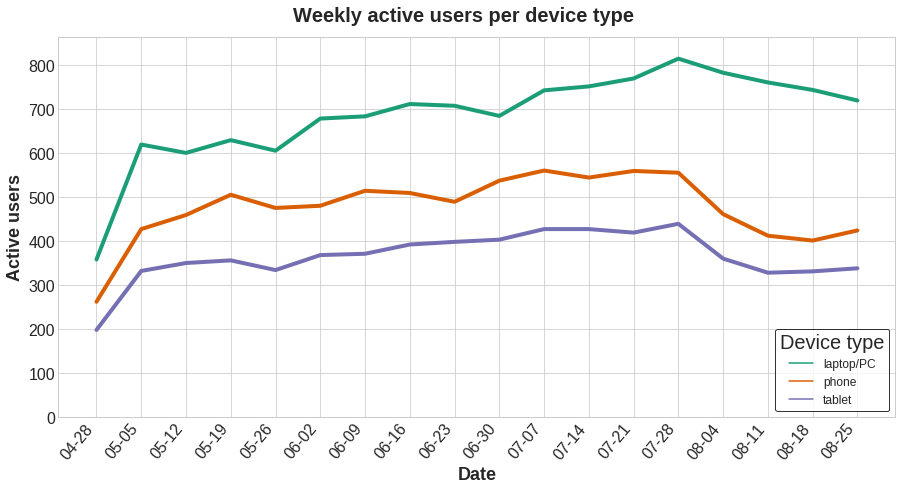

In [257]:
with plt.style.context('seaborn-whitegrid'):
    
    fig, ax = plt.subplots(figsize=(15,7))
    fig.suptitle("Weekly active users per device type", fontsize=20, fontweight=550, y=0.94)  
    
    ax=sns.lineplot(x="week", y="active_users", data=device_1, hue="device_type", palette="Dark2", lw=4) 
    ax.set_ylim(0, device_1.active_users.max()+50)
    ax.tick_params(axis="x", labelsize=16, rotation=50)
    ax.tick_params(axis="y", labelsize=16)
    ax.set_xlabel("Date", fontsize=18, fontweight=650)
    ax.set_ylabel("Active users", fontsize=18, fontweight=650)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(loc="lower right", handles=handles[1:], labels=labels[1:], prop={'size': 12}, frameon="yes",
              edgecolor="black", title="Device type", title_fontsize=20)

    plt.show()

In [153]:
query_model_device = """
SELECT device_type, active_users_t0, active_users, (active_users-active_users_t0) AS variation_drop,
 ROUND(CAST(((active_users::float-active_users_t0::float) / active_users_t0)*100 as numeric) ,2) AS variation_pct
FROM(
    SELECT sub3.*
    FROM(
        SELECT sub2.*, LAG(sub2.active_users, 1) OVER (PARTITION BY sub2.device_type) AS active_users_t0
        FROM(
            SELECT sub1.device_type AS device_type, EXTRACT('month' FROM occurred_at::date) AS month,
             COUNT(DISTINCT user_id) as active_users
            FROM(
                SELECT *,
                CASE WHEN device IN ('nexus 10', 'windows surface', 'nexus 7', 'kindle fire') 
                      OR device LIKE '%%pad%%' OR device ILIKE '%%tablet%%' THEN 'tablet'
                     WHEN device IN ('nexus 5', 'samsung galaxy note', 'samsung galaxy s4', 'htc one', 'nokia 635')
                      OR device LIKE '%%phone%%' THEN 'phone'
                     ELSE 'laptop/PC' END AS device_type
                FROM events
                ) sub1
            WHERE event_name = 'login'
            GROUP BY device_type, month
            ) sub2
        ) sub3
    WHERE sub3.month = 8
    ) sub4;  
"""

device_2 = pd.read_sql(query_model_device, engine)

In [154]:
device_2.style.format({"variation_pct":"{:.2f}%"})

,device_type,active_users_t0,active_users,variation_drop,variation_pct
0,laptop/PC,2000,1936,-64,-3.20%
1,phone,1683,1276,-407,-24.18%
2,tablet,1256,1050,-206,-16.40%


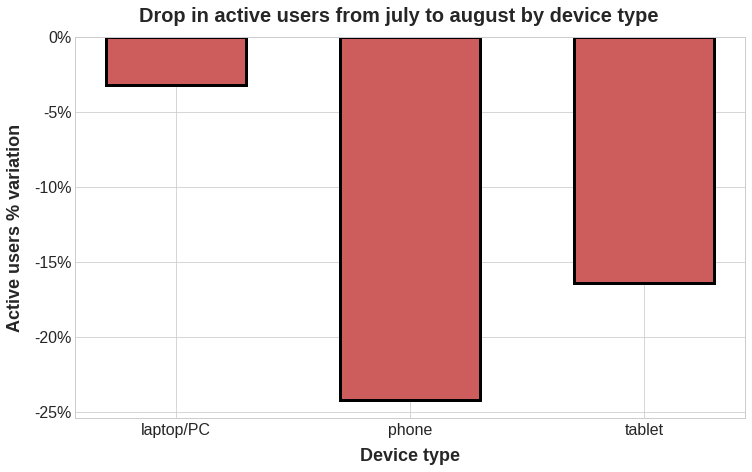

In [263]:
with plt.style.context('seaborn-whitegrid'):
    
    fig, ax = plt.subplots(figsize=(12,7))
    fig.suptitle("Drop in active users from july to august by device type", fontsize=20, fontweight=650, y=0.94)
    
    ax.bar(device_2["device_type"], device_2["variation_pct"], color="indianred", width=0.6,
            edgecolor="black", linewidth=3)
    ax.tick_params(axis="x", labelsize=16, pad=5)
    ax.tick_params(axis="y", labelsize=16)
    ax.set_xlabel("Device type", fontsize=18, fontweight=650, labelpad=10)
    ax.set_ylabel("Active users % variation", fontsize=18, fontweight=650, labelpad=10)
    
    ylabels = ['{:,.0f}%'.format(x) for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)

    plt.show()

### Operative system

In [220]:
query_operative_system = """
SELECT sub1.device_os AS device_os,
 SUBSTR(((DATE_TRUNC('week', occurred_at::date)))::text, 6, 5) AS week,
 COUNT(DISTINCT user_id) as active_users
FROM(
    SELECT *,
    CASE WHEN device LIKE 'i%%' OR device ILIKE '%%mac%%' THEN 'apple'
     WHEN device LIKE '%%nexus%%' OR device LIKE '%%galaxy%%' OR device LIKE '%%nokia%%'
      OR device LIKE '%%HTC%%' THEN 'android'
     WHEN device LIKE '%%fire%%' THEN 'fire os'
     ELSE 'windows' END AS device_os
    FROM events
    ) sub1
WHERE event_name = 'login'
GROUP BY device_os, week
ORDER BY week, device_os; 
"""

operative_system_1 = pd.read_sql(query_operative_system, engine)

In [223]:
operative_system_1.head(10)

,device_os,week,active_users
0,android,04-28,164
1,apple,04-28,376
2,fire os,04-28,10
3,windows,04-28,246
4,android,05-05,253
5,apple,05-05,601
6,fire os,05-05,35
7,windows,05-05,426
8,android,05-12,270
9,apple,05-12,638


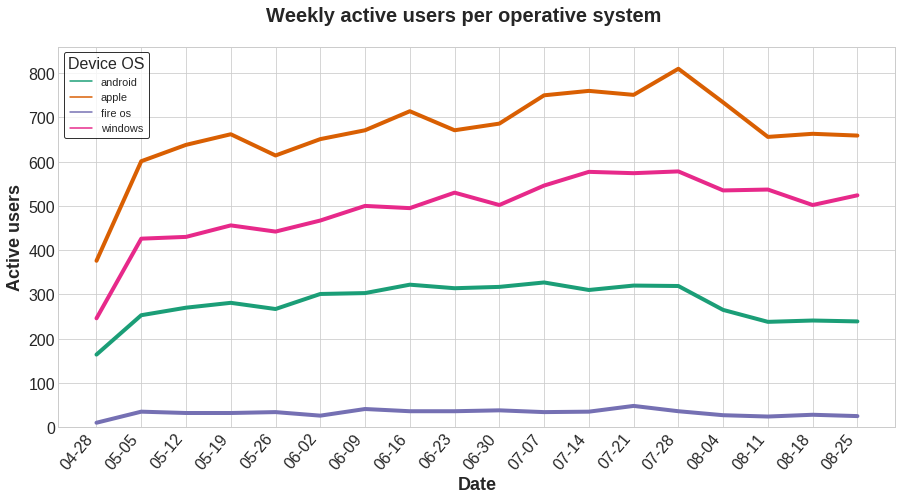

In [265]:
with plt.style.context('seaborn-whitegrid'):
    
    fig, ax = plt.subplots(figsize=(15,7))
    fig.suptitle("Weekly active users per operative system", fontsize=20, fontweight=650, y=0.96)  
    
    ax=sns.lineplot(x="week", y="active_users", data=operative_system_1, hue="device_os", palette="Dark2", lw=4) 
    ax.set_ylim(0, operative_system_1.active_users.max()+50)
    ax.tick_params(axis="x", labelsize=16, rotation=50)
    ax.tick_params(axis="y", labelsize=16)
    ax.set_xlabel("Date", fontsize=18, fontweight=650)
    ax.set_ylabel("Active users", fontsize=18, fontweight=650)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(loc="upper left", handles=handles[1:], labels=labels[1:], prop={'size': 11}, frameon="yes",
              edgecolor="black", title="Device OS", title_fontsize=16)

    plt.show()

In [216]:
query_operative_system = """
SELECT device_os, active_users_t0, active_users, (active_users-active_users_t0) AS variation_drop,
 ROUND(CAST(((active_users::float-active_users_t0::float) / active_users_t0)*100 as numeric) ,2) AS variation_pct
FROM(
    SELECT sub3.*
    FROM(
        SELECT sub2.*, LAG(sub2.active_users, 1) OVER (PARTITION BY sub2.device_os) AS active_users_t0
        FROM(
            SELECT sub1.device_os AS device_os, EXTRACT('month' FROM occurred_at::date) AS month,
             COUNT(DISTINCT user_id) as active_users
            FROM(
                SELECT *,
                CASE WHEN device LIKE 'i%%' OR device ILIKE '%%mac%%' THEN 'apple'
                     WHEN device LIKE '%%nexus%%' OR device LIKE '%%galaxy%%' OR device LIKE '%%nokia%%'
                      OR device LIKE '%%HTC%%' THEN 'android'
                     WHEN device LIKE '%%fire%%' THEN 'fire os'
                     ELSE 'windows' END AS device_os
                FROM events
                ) sub1
            WHERE event_name = 'login'
            GROUP BY device_os, month
            ) sub2
        ) sub3
    WHERE sub3.month = 8
    ) sub4;
"""

operative_system_2 = pd.read_sql(query_operative_system, engine)

In [217]:
operative_system_2.style.format({"variation_pct":"{:.2f}%"})

,device_os,active_users_t0,active_users,variation_drop,variation_pct
0,android,948,735,-213,-22.47%
1,apple,1997,1769,-228,-11.42%
2,fire os,124,84,-40,-32.26%
3,windows,1500,1441,-59,-3.93%


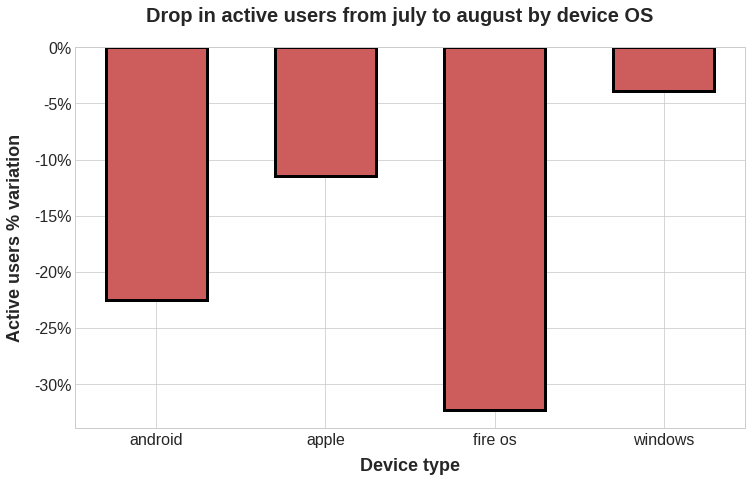

In [288]:
with plt.style.context('seaborn-whitegrid'):
    
    fig, ax = plt.subplots(figsize=(12,7))
    fig.suptitle("Drop in active users from july to august by device OS",
                 fontsize=20, fontweight=650, y=0.96)
    
    ax.bar(operative_system_2["device_os"], operative_system_2["variation_pct"], color="indianred", width=0.6,
        edgecolor="black", linewidth=3)
    ax.tick_params(axis="x", labelsize=16, pad=5)
    ax.tick_params(axis="y", labelsize=16)
    ax.set_xlabel("Device type", fontsize=18, fontweight=650, labelpad=10)
    ax.set_ylabel("Active users % variation", fontsize=18, fontweight=650, labelpad=10)
    
    ylabels = ['{:,.0f}%'.format(x) for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)

    plt.show()

## Specific feature flow/broken tracking code

### Usage flow

*It might be the case that some specific feature within the usage flow was broken at some point close to end of july or within august, hence causing a bad user experience and in consequence prompting users to be less engaged on posterior days to that hypothetical malfunctioning.*

In [269]:
query_usage_flow = """
SELECT SUBSTR(((DATE_TRUNC('week', occurred_at::date)))::text, 6, 5) AS week, event_name,
 COUNT(user_id) AS event_count
FROM events
WHERE event_type = 'engagement'AND event_name NOT LIKE '%%result%%' --This last statement is optional. It is just to exclude the various search results
GROUP BY week, event_name
ORDER BY week;
"""

usage_flow = pd.read_sql(query_usage_flow, engine)

In [271]:
usage_flow.head(10)

,week,event_name,event_count
0,04-28,home_page,2546
1,04-28,like_message,1657
2,04-28,login,967
3,04-28,search_autocomplete,424
4,04-28,search_run,358
5,04-28,send_message,904
6,04-28,view_inbox,1510
7,05-05,home_page,5113
8,05-05,like_message,3382
9,05-05,login,1999


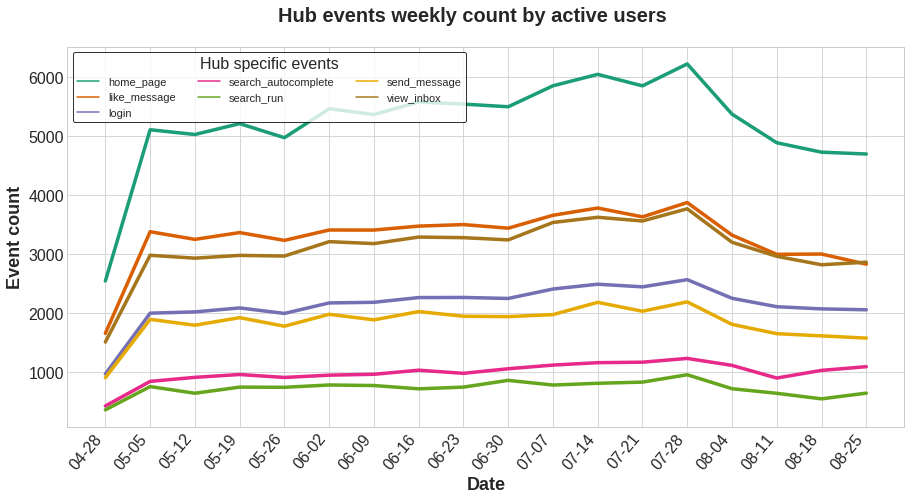

In [289]:
with plt.style.context('seaborn-whitegrid'):
    
    fig, ax = plt.subplots(figsize=(15,7))
    fig.suptitle("Hub events weekly count by active users", fontsize=20, fontweight=650, y=0.96)  
    
    ax=sns.lineplot(x="week", y="event_count", data=usage_flow, hue="event_name", palette="Dark2", lw=3.5) 
    #ax.set_ylim(0, operative_system_1.active_users.max()+50)
    ax.tick_params(axis="x", labelsize=16, rotation=50)
    ax.tick_params(axis="y", labelsize=16)
    ax.set_xlabel("Date", fontsize=18, fontweight=650)
    ax.set_ylabel("Event count", fontsize=18, fontweight=650)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(loc="upper left", handles=handles[1:], labels=labels[1:], prop={'size': 11}, frameon="yes",
              edgecolor="black", title="Hub specific events", title_fontsize=16, ncol=3)

    plt.show()

*Above query's result shows that there is not any specific feature within the usage flow (not considering the signup steps) that because
of its malfunctioning in t-1 is causing in t a drop in user engagement, since all of the features are moving in sync*

### Signup flow potential issue

#### 1st, it is convenient to check the new users per month

In [64]:
query_signup_flow = """
SELECT DISTINCT state
FROM users;
"""
signup_flow_0 = pd.read_sql(query_signup_flow, engine)

In [65]:
signup_flow_0.head()

,state
0,pending
1,active


In [333]:
query_signup_flow = """
SELECT sub2.*, 
 ROUND(CAST(((monthly_new_users::float-lag::float) / lag)*100 as numeric) ,2) AS new_users_variation_pct
FROM(
    SELECT sub1.*,
     LAG(sub1.monthly_new_users, 1) OVER () AS lag
    FROM(
        SELECT LEFT((DATE_TRUNC('month', created_at::date)::text), 7) AS month, 
         COUNT(DISTINCT user_id) AS monthly_new_users
        FROM users
        WHERE state='active'
        GROUP BY month
        )sub1
    )sub2;
"""
signup_flow_1= pd.read_sql(query_signup_flow, engine)

In [334]:
signup_flow_1

,month,monthly_new_users,lag,new_users_variation_pct
0,2013-01,160,NaN,NaN
1,2013-02,160,160.0,0.00
2,2013-03,150,160.0,-6.25
3,2013-04,181,150.0,20.67
4,2013-05,214,181.0,18.23
5,2013-06,213,214.0,-0.47
6,2013-07,284,213.0,33.33
7,2013-08,316,284.0,11.27
8,2013-09,330,316.0,4.43
9,2013-10,390,330.0,18.18


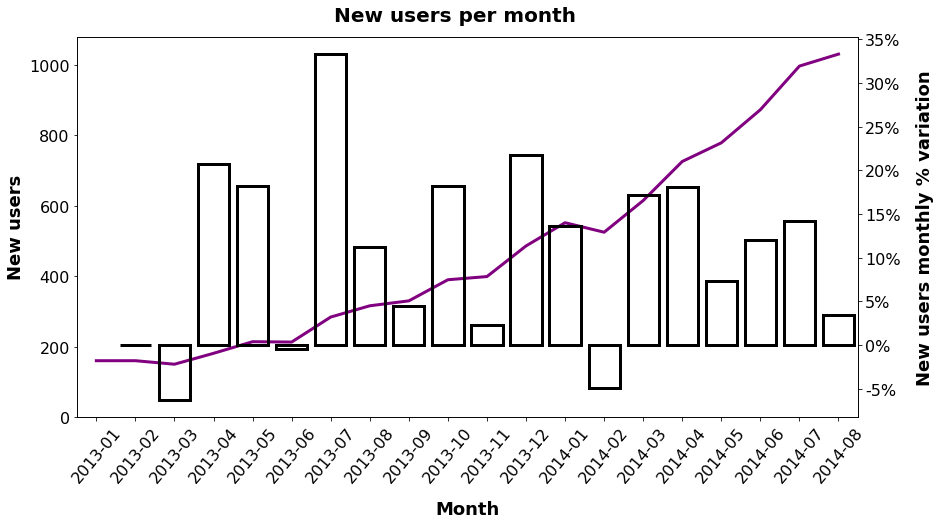

In [335]:
with plt.style.context('seaborn-colorblind'):
    fig, ax1 = plt.subplots(figsize=(14,7))
    fig.suptitle("New users per month", fontsize=20, fontweight=650, y=0.94) 
    ax2 = ax1.twinx()
    
    sns.lineplot(signup_flow_1["month"], signup_flow_1["monthly_new_users"], lw=3, color="purple", ax=ax1)
    ax1.set_ylim(0, signup_flow_2.monthly_new_users.max()+50)
    ax1.tick_params(axis="x", labelsize=16, rotation=50)
    ax1.tick_params(axis="y", labelsize=16)
    ax1.set_xlabel("Month", fontsize=18, fontweight=650, labelpad=15)
    ax1.set_ylabel("New users", fontsize=18, fontweight=650)
    
    sns.barplot(signup_flow_1["month"], signup_flow_1["new_users_variation_pct"], facecolor=(0, 0, 0, 0),
        edgecolor="black", linewidth=3, ax=ax2)
    ax2.tick_params(axis="x", labelsize=16, pad=10)
    ax2.tick_params(axis="y", labelsize=16)
    ax2.set_xlabel("Device type", fontsize=18, fontweight=650, labelpad=15)
    ax2.set_ylabel("New users monthly % variation", fontsize=18, fontweight=650, labelpad=15)
    
    ylabels = ['{:,.0f}%'.format(x) for x in ax2.get_yticks()]
    ax2.set_yticklabels(ylabels)


#### 2nd, this is the conversion funnel for the 4 months we have info on the log events.

In [336]:
query_signup_flow = """
SELECT DISTINCT event_name
FROM events
WHERE event_type='engagement';
"""
signup_flow_01 = pd.read_sql(query_signup_flow, engine)

In [337]:
query_signup_flow = """
SELECT *
FROM events
WHERE event_type='signup_flow';
"""
signup_flow_02 = pd.read_sql(query_signup_flow, engine)

In [338]:
query_signup_flow = """
SELECT sub.*
FROM(
    SELECT DATE_TRUNC('month', users.created_at::date) AS activation_month,
     COUNT(DISTINCT CASE WHEN events.event_name = 'create_user' THEN events.user_id ELSE null END) AS user_created_count,
     COUNT(DISTINCT CASE WHEN events.event_name = 'enter_email' THEN events.user_id ELSE null END) AS enter_email_count,
     COUNT(DISTINCT CASE WHEN events.event_name = 'enter_info' THEN events.user_id ELSE null END) AS enter_info_count,
     COUNT(DISTINCT CASE WHEN events.event_name = 'complete_signup' THEN events.user_id ELSE null END) AS complete_signup_count
    FROM events
    JOIN users
    ON users.user_id = events.user_id
    GROUP BY activation_month
    )sub
WHERE activation_month >= '2014-05-01 00:00:00';
"""
signup_flow_2 = pd.read_sql(query_signup_flow, engine)

In [339]:
signup_flow_2.head()

,activation_month,user_created_count,enter_email_count,enter_info_count,complete_signup_count
0,2014-04-30 22:00:00+00:00,1597,955,825,779
1,2014-05-31 22:00:00+00:00,1728,1067,925,873
2,2014-06-30 22:00:00+00:00,1983,1189,1043,997
3,2014-07-31 22:00:00+00:00,1990,1196,1079,1031


*Check chart and comment. This confirms that signup flow has not been the reason*

### MK campaign/promotions

In [73]:
query_mk = """
SELECT EXTRACT ('month' FROM occurred_at::date) AS month, action, COUNT(action) AS number_actions
FROM emails
GROUP BY month, action
ORDER BY month, number_actions DESC;
"""
mk_1 = pd.read_sql(query_mk, engine)

Presented in a pivot table format for chart consumption

In [77]:
query_mk = """
SELECT LEFT(week::text, 10) AS week_summary,
 ROUND(CAST((email_open::float/total_emails_sent::float) as numeric), 2) AS email_open_rate,
 ROUND(CAST((email_clickthrough::float/email_open::float) as numeric), 2) AS email_clickthrough_rate
FROM(
    SELECT sub.*, (sent_weekly_digest + sent_reengagement_email) AS total_emails_sent
    FROM(
        SELECT DATE_TRUNC('week', occurred_at::date) AS week,
         COUNT(CASE WHEN action = 'sent_weekly_digest' THEN user_id ELSE NULL END) AS sent_weekly_digest,
         COUNT(CASE WHEN action = 'sent_reengagement_email' THEN user_id ELSE NULL END) AS sent_reengagement_email,
         COUNT(CASE WHEN action = 'email_open' THEN user_id ELSE NULL END) AS email_open,
         COUNT(CASE WHEN action = 'email_clickthrough' THEN user_id ELSE NULL END) AS email_clickthrough
        FROM emails
        GROUP BY week
        ) sub
    ) sub2
ORDER BY week_summary;
"""
mk_2 = pd.read_sql(query_mk, engine)

In [78]:
mk_2

,week_summary,email_open_rate,email_clickthrough_rate
0,2014-04-28,0.33,0.56
1,2014-05-05,0.33,0.47
2,2014-05-12,0.34,0.49
3,2014-05-19,0.34,0.50
4,2014-05-26,0.34,0.44
5,2014-06-02,0.32,0.50
6,2014-06-09,0.34,0.50
7,2014-06-16,0.35,0.48
8,2014-06-23,0.32,0.48
9,2014-06-30,0.33,0.48


### Bad data. QA/bots

*In order to ascertain whether this is the cause we need to see activity by user and check whether there is unusual activity by few of them. This would cause artificial activity or in other words, a certain kind of spike/unusual rise, which in our case could make sense to have it in july. If this happened to be true, we could say that august drop in user engagement is not such, because it would be rather a problem of fake user engagement in the preceding month.*

First I am going to check whether there is anyone starting engaging with the web but not loging in, this would be pointing to both bots and QA that maybe dont need to sign up (especially bots).

In [79]:
query_bad_data = """
SELECT sub2.*
FROM(
    SELECT sub.*, ROW_NUMBER() OVER (PARTITION BY user_id, day ORDER BY occurred_at::date) AS user_events_per_day
    FROM(
        SELECT *, DATE_TRUNC('day', occurred_at::date) AS day
        FROM events
        WHERE event_type = 'engagement'
        ) sub
    ) sub2
WHERE user_events_per_day = 1 AND event_name != 'login' 
 AND EXTRACT('hour' FROM occurred_at::date)!=0; -- Taking those at 12am that were logged minutes before but in the previous day.
"""
qa_bots = pd.read_sql(query_bad_data, engine)

In [80]:
qa_bots

,user_id,occurred_at,event_type,event_name,location,device,user_type,day,user_events_per_day


Second, let's see if there are some days with unusual activity (maybe happening in july at the most).

In [81]:
query_bad_data = """
SELECT user_id, sub.day, COUNT(event_name) AS number_events_per_day
FROM(
    SELECT *, DATE_TRUNC('day', occurred_at::date) AS day
    FROM events
    WHERE event_type = 'engagement'
    ) sub
GROUP BY user_id, day
ORDER BY number_events_per_day DESC;

"""
qa_bots_2 = pd.read_sql(query_bad_data, engine)

Third, and as an extension from previous query, let's group them by user_id to identify those that have a greater (unusual?) activity.

In [82]:
query_bad_data = """
SELECT user_id, month, AVG(number_events_per_day) AS avg_daily_events
FROM(
    SELECT user_id, sub.day,
     EXTRACT('month' FROM sub.day) AS month,
     COUNT(event_name) AS number_events_per_day
    FROM(
        SELECT *, DATE_TRUNC('day', occurred_at::date) AS day
        FROM events
        WHERE event_type = 'engagement'
        ) sub
    GROUP BY user_id, day
    ) sub2
GROUP BY month, user_id
ORDER BY avg_daily_events DESC, month; 
"""
qa_bots_3 = pd.read_sql(query_bad_data, engine)

A query for checking a that july has more activity, but as in 3rd step i try to show that there does not seem to have an unusual activity above the rest

In [83]:
query_bad_data = """

SELECT month, SUM(avg_daily_events)
FROM(
    SELECT user_id, month, AVG(number_events_per_day) AS avg_daily_events
    FROM(
        SELECT user_id, sub.day,
         EXTRACT('month' FROM sub.day) AS month,
         COUNT(event_name) AS number_events_per_day
        FROM(
            SELECT *, DATE_TRUNC('day', occurred_at::date) AS day
            FROM events
            WHERE event_type = 'engagement'
            ) sub
        GROUP BY user_id, day
        ) sub2
    GROUP BY month, user_id
    ORDER BY avg_daily_events DESC, month
    ) sub3
GROUP BY month;

"""
qa_bots_4 = pd.read_sql(query_bad_data, engine)

Just a dummy query for verification of the 3rd point

In [84]:
query_bad_data = """
SELECT user_id, sub.month, COUNT(event_name)
FROM(
    SELECT *, DATE_TRUNC('day', occurred_at::date) AS month
    FROM events
    WHERE event_type='engagement'
    )sub
WHERE user_id = 59
GROUP BY user_id, sub.month;
"""
qa_bots_5 = pd.read_sql(query_bad_data, engine)